# To examine how offset and scale influence the initial qualtiy of predictions

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import pickle
import matplotlib.pyplot as plt
import os
import hydra
from omegaconf import DictConfig
import os
import numpy as np
import sys
import glob
sys.path.append('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph')
from utils.data_utils import read_data,build_avg_recordings,build_training_data
import yaml
import itertools


# Define default save directory. Can be overwritten by command-line argument
save_dir = '/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/debugging/figs/grid_search_offset_scale'
os.makedirs(save_dir, exist_ok=True)
results_base = '/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/results/train_runs/grid_search_offset_scale'
relative_config_path = '.hydra/config.yaml'
labels_base = '/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/results/train_runs/2020-08-29_64_pts_rec_ids_012_scale_35_offset_-1_5/0'
cwd = os.getcwd()
matplotlibrc_dir = '/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc'

# which rois/compartments are part of which field and therefore 
number_of_recordings_each_scanfield = [8, 3, 5]

roi_field_id = []
for idx,i in enumerate(number_of_recordings_each_scanfield):
    roi_field_id.append([idx] * i)
roi_field_id = list(itertools.chain(*roi_field_id))

matplotlib.rc_file(f"{matplotlibrc_dir}/.matplotlibrc")


## load all files in results_base folder and load the config as a dict and store the dicts in a list

In [3]:
def retrieve_meta_data(results_base,training_run_file,relative_config_path):
    '''
    Retrieves the data from the training_run_file and the relative config path.

    '''
    # read the .yaml file as a dict
    config_path = os.path.join(results_base,training_run_file,'0',relative_config_path)
    with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    
    return config

In [4]:
def test_ids_for_split(results_base,training_run_file,labels_base,split):
    file_path = os.path.join(results_base, training_run_file,
                             '0','data', f'{split}_inds.pkl')
    with open(file_path, 'rb') as f:
        inds_train_run = pickle.load(f)

    file_path_labels = os.path.join(labels_base, 'data', f'{split}_inds.pkl')
    with open(file_path_labels, 'rb') as f:
        inds_labels = pickle.load(f)

    assert type(inds_train_run) == type(inds_labels) == np.ndarray

    assert (inds_train_run == inds_labels).all()
    return inds_train_run

### check if the inds are the same for the file we got the labels from and the file we got the data from

In [5]:

def load_predictions(results_base, training_run_file, split):
    """
    Loads the predictions dictionary/array for the specified training run and split.
    
    Parameters:
    -----------
    results_base : str
        Base directory containing training results.
    training_run_file : str
        Name (subdirectory) of the specific training run.
    split : str
        Data split to load (e.g. 'train', 'valid', 'test').

    Returns:
    --------
    predictions : np.ndarray or dict
        The loaded predictions object.
    """
    file_path = os.path.join(results_base, training_run_file,
                             '0', 'predictions_labels',
                             f'predictions_epoch_-1_split_{split}.pkl')
    with open(file_path, 'rb') as f:
        predictions = pickle.load(f)
    return predictions


In [6]:

def load_labels(results_base, training_run_file, split):
    """
    Loads the labels (ground truth) for the specified training run and split.
    
    Parameters:
    -----------
    results_base : str
        Base directory containing training results.
    training_run_file : str
        Name (subdirectory) of the specific training run.
    split : str
        Data split to load (e.g. 'train', 'valid', 'test').

    Returns:
    --------
    labels : np.ndarray
        The loaded labels object.
    """
    file_path = os.path.join(results_base, 
                             training_run_file,'0','predictions_labels',
                             f'labels_split_{split}.pkl')
    with open(file_path, 'rb') as f:
        labels = pickle.load(f)
    return labels


In [7]:

def calculate_correlation(results_base, training_run_file, split,inds,num_datapoints_per_scanfield):
    """
    Loads the predictions and labels, then computes per-ROI correlation
    between predictions and labels.
    
    Assumes that predictions and labels have shape (n_samples, n_rois).
    The correlation is calculated across samples for each ROI.

    Parameters:
    -----------
    results_base : str
        Base directory containing training results.
    training_run_file : str
        Name (subdirectory) of the specific training run.
    split : str
        Data split to evaluate (e.g. 'train', 'valid', 'test').

    Returns:
    --------
    correlations : np.ndarray
        A 1D array of correlation values, one for each ROI.
    """
    preds = load_predictions(results_base, training_run_file, split)
    labels = load_labels(results_base, training_run_file, split)
  
    # Ensure they are numpy arrays
    preds = np.array(preds)
    labels = np.array(labels)

    assert len(inds) == preds.shape[0] == labels.shape[0], f"Length mismatch between indices {len(inds)}, predictions {preds.shape[0]}, and labels {labels.shape[0]}."

    # Check shapes
    if preds.shape != labels.shape:
        raise ValueError(f"Shape mismatch between predictions {preds.shape} and labels {labels.shape}.")

    # Number of ROIs is the second dimension
    n_samples, n_rois = preds.shape
    correlations = np.zeros(n_rois, dtype=float)
    
    for i in range(n_rois):

        # get which indices in preds,labels correspond to the i-th ROI
        field = roi_field_id[i]
        roi_measured = np.where(inds//num_datapoints_per_scanfield == field)        
        

        corr = np.corrcoef(preds[roi_measured, i], labels[roi_measured, i])[0, 1]
        correlations[i] = corr
    
    return correlations


In [8]:

def plot_correlations(ax, correlations):
    """
    Plots correlation values for each ROI on a given axis.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Matplotlib axis on which to draw the plot.
    correlations : list or np.ndarray
        A list/array of correlation values, one per ROI.
    """
    rois = np.arange(len(correlations))
    ax.plot(rois, correlations, marker='o', linestyle='-', color='b')
    ax.set_xlabel('ROI Index')
    ax.set_ylabel('Correlation')
    ax.set_title('Per-ROI Correlation')
    ax.axhline(y=0, color='r', linestyle='--')  # a reference line at 0 
    ax.axhline(y= np.mean(correlations),color='black',linestyle='--',label= f'Mean Correlation: {np.mean(correlations):.2f}')
    ax.legend()

In [9]:

def plot_correlations_for_split(ax, results_base, training_run_file, split,meta_data,inds):
    """
    Uses the passed-in axis (ax) to display the per-ROI correlation
    for a given training run and data split.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Matplotlib axis on which to draw the plot.
    results_base : str
        Base directory containing training results.
    training_run_file : str
        Name (subdirectory) of the specific training run.
    split : str
        Data split to evaluate (e.g. 'train', 'valid', 'test').
    """
    # add correlation s to plot
    num_datapoints_per_scanfield = meta_data['num_datapoints_per_scanfield']
    correlations = calculate_correlation(results_base, training_run_file, split,inds,num_datapoints_per_scanfield)
    plot_correlations(ax, correlations)

    keys = ['output_scale', 'output_offset','scale_by_bc_number']

    # add metadata to plot
    title_str = "Rhos " + " ".join([key + ': ' + str(meta_data[key]) for key in keys])
    ax.set_title(title_str)
    
    return correlations


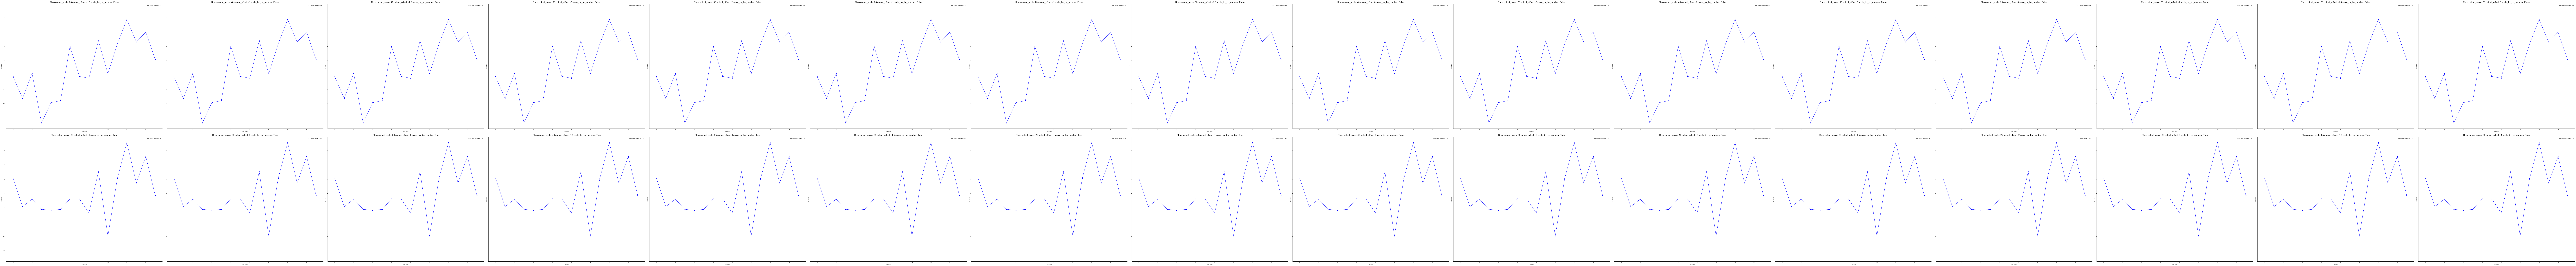

Best run: 2025_02_19__01_13_55 with mean correlation 0.10 and config {'debugging_figs': ['recording_comps_and_rois'], 'cell_id': '2020-08-29_1', 'lr': 0.005, 'momentum': 0.5, 'iterations': 1, 'reduce_lr_every': 800, 'reduce_lr_by': 5, 'beta': 0.99, 'soma_radius': 7.5, 'output_scale': 30, 'output_offset': -2, 'scale_by_bc_number': True, 'weight_init': 0.1, 'batchsize': 2, 'rec_ids': [0, 1, 2], 'num_datapoints_per_scanfield': 64, 'val_frac': 0.25, 'test_num': 8, 'vis': False, 'seed_weights': 10, 'seed_membrane_conds': 0, 'seed_tf_dataloader': 0, 'seed_tf_train_loop': 0, 'seed_ruler': 0, 'eval_every_nth_batch': 100, 'start_n_scan': 100, 'nseg': 4, 'reuse_avg_recordings': False}


In [10]:
def run_all(results_base, training_run_files, split='test'):
    """
    Loads predictions/labels for each training run in `training_run_files`,
    computes per-ROI correlations, and plots them all in a single figure.

    Parameters:
    -----------
    results_base : str
        The base path to the results.
    training_run_files : list of str
        The names of the subdirectories for each training run.
    split : str
        Which data split to process (e.g. 'train', 'valid', 'test').
    """
    n_runs = len(training_run_files)
    fig, axes = plt.subplots(2, int(np.ceil(n_runs/2)), figsize=(6 * n_runs, 20), sharey=True)
    

    # If there's only one run, axes will not be an array.
    if n_runs == 1:
        axes = [axes]

    col_idx_axes = [0,0]
    all_correls = []
    config_dicts = []
    for idx, trf in enumerate(training_run_files):
        # check if test ids are the same
        inds = test_ids_for_split(results_base, trf, labels_base, split
        )
                
        # get meta data
        config_dict = retrieve_meta_data(results_base,trf,relative_config_path)
        config_dicts.append(config_dict)

        # determine where to plot
        row_idx = 1 if config_dict['scale_by_bc_number'] else 0 
        ax = axes[row_idx][col_idx_axes[row_idx]]
        col_idx_axes[row_idx] += 1

        correl = plot_correlations_for_split(ax, results_base, trf, split,config_dict,inds)
        all_correls.append(np.mean(correl))

    plt.tight_layout()
    plt.show()
    all_correls = np.array(all_correls)
    max_idx = np.argmax(all_correls)
    print(f"Best run: {training_run_files[max_idx]} with mean correlation {all_correls[max_idx]:.2f} and config {config_dicts[max_idx]}")
    


training_run_files = os.listdir(results_base)
run_all(results_base, training_run_files, split='train')


In [11]:
def plot_predictions_vs_labels_for_roi(results_base, training_run_files, roi, split='test',save_fig_base=False):
    """
    Creates a figure with one subplot per training run, plotting the predictions
    vs. the labels for the specified ROI (compartment) as a time series.

    Parameters:
    -----------
    results_base : str
        Base directory for the training results.
    training_run_files : list of str
        The names of subdirectories for each training run.
    roi : int
        The index of the ROI/compartment to plot.
    split : str
        Which data split to load (e.g. 'train', 'valid', 'test').
    """
    n_runs = len(training_run_files)
    n_rows = int(np.ceil(np.sqrt(n_runs)))
    fig, axes = plt.subplots(n_rows,n_rows, figsize=(2*n_runs, 2*n_runs), sharey=True)

    axes = axes.flatten() if n_runs > 1 else [axes]



    maes = []
    correls = []
    configs = []

    for ax, trf in zip(axes, training_run_files):
        # load predictions and labels
        preds = load_predictions(results_base, trf, split)
        labs = load_labels(results_base, trf, split)
        inds = test_ids_for_split(results_base, trf, labels_base, split)
        
        num_datapoints_per_scanfield = retrieve_meta_data(results_base, trf, relative_config_path)['num_datapoints_per_scanfield']
        field = roi_field_id[roi]
        roi_measured = np.where(inds//num_datapoints_per_scanfield == field)
        preds = preds[roi_measured]
        labs = labs[roi_measured]
        mae = np.mean(np.abs(preds - labs))
        maes.append(mae)
        correl = np.corrcoef(preds[:, roi], labs[:, roi])[0, 1]
        correls.append(correl)

        # time axis = index of samples
        time_axis = np.arange(len(preds[:, roi]))
        
        ax.plot(time_axis, preds[:, roi], label='Predictions', color='blue')
        ax.plot(time_axis, labs[:, roi], label='Labels', color='orange')
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Response')

        # gather config metadata for the title
        config_dict = retrieve_meta_data(results_base, trf, relative_config_path)
        configs.append(config_dict)
        offset = config_dict.get('output_offset', None)
        scale = config_dict.get('output_scale', None)
        bc_scale = config_dict.get('scale_by_bc_number', None)

        ax.set_title(f"Run: {trf}\nROI {roi}, Offset={offset}, Scale={scale}, BC_Scale={bc_scale}, MAE={mae:.2f}, rho={correl:.2f}")
        ax.legend()

    max_correl_idx = np.argmax(correls)
    max_mae_idx = np.argmin(maes)
    
    print(f"Best correlation: {training_run_files[max_correl_idx]} with correlation {correls[max_correl_idx]:.2f} maes {maes[max_mae_idx]} and config {configs[max_correl_idx]}")
    print(f"Best MAE: {training_run_files[max_mae_idx]} with MAE {maes[max_mae_idx]:.2f} correlation {correls[max_correl_idx]:.2f} and config {configs[max_mae_idx]}")

    plt.tight_layout()

    if save_fig_base:
        plt.savefig(os.path.join(save_fig_base,f'predictions_vs_labels_roi_{roi}_split_{split}.pdf'))

    else:
        plt.show()
    plt.close(fig)
    return ((max_correl_idx,correls[max_correl_idx],configs[max_correl_idx]),(max_mae_idx,maes[max_mae_idx],configs[max_mae_idx]))



In [14]:
def analyze_all_rois(
    results_base,
    training_run_files,
    rois,
    split='test',
    save_figs=False
):
    """
    Loops over each ROI in `rois`, calls `plot_predictions_vs_labels_for_roi`,
    stores the best (highest) correlation and best (lowest) MAE config values (offset/scale)
    for each ROI, and finally creates histograms of the most common offset/scale.

    Parameters:
    -----------
    results_base : str
        Base directory for the training results.
    training_run_files : list of str
        Subdirectories for each training run.
    rois : list of int
        The ROI indices to analyze.
    split : str
        Data split to load (e.g. 'train', 'valid', 'test').
    save_figs : bool or str
        If True, a new directory is created (or used) to store the ROI plots.
        If a string, that path is used as the save directory.

    Returns:
    --------
    None
    """
    # Prepare a directory to save individual ROI figures
    if save_figs:
        if isinstance(save_figs, str):
            roi_save_dir = save_figs
        else:
            roi_save_dir = os.path.join(save_dir, 'roi_plots')
        os.makedirs(roi_save_dir, exist_ok=True)
    else:
        roi_save_dir = None

    best_corr_offsets = []
    best_corr_scales = []
    best_mae_offsets = []
    best_mae_scales = []

    for roi in rois:
        print(f"Analyzing ROI {roi}...")
        # For each ROI, we call the existing function to produce the figure
        best_corr_info, best_mae_info = plot_predictions_vs_labels_for_roi(
            results_base,
            training_run_files,
            roi,
            split=split,
            save_fig_base=roi_save_dir
        )
        # best_corr_info = (max_correl_idx, max_corr_val, best_corr_config)
        # best_mae_info = (min_mae_idx, min_mae_val, best_mae_config)

        best_corr_config = best_corr_info[2]
        best_mae_config = best_mae_info[2]

        # Collect offset/scale from best correlation
        best_corr_offsets.append(best_corr_config.get('output_offset', None))
        best_corr_scales.append(best_corr_config.get('output_scale', None))

        # Collect offset/scale from best MAE
        best_mae_offsets.append(best_mae_config.get('output_offset', None))
        best_mae_scales.append(best_mae_config.get('output_scale', None))

    # Now we create a histogram showing the most common offset/scale for each scenario
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Offsets
    axes[0].hist(best_corr_offsets, alpha=0.5, label='Best Corr Offsets')
    axes[0].hist(best_mae_offsets, alpha=0.5, label='Best MAE Offsets')
    axes[0].set_xlabel('output_offset')
    axes[0].set_ylabel('Count')
    axes[0].legend()
    axes[0].set_title('Histogram of Offsets (Best Corr vs Best MAE)')

    # Scales
    axes[1].hist(best_corr_scales, alpha=0.5, label='Best Corr Scales')
    axes[1].hist(best_mae_scales, alpha=0.5, label='Best MAE Scales')
    axes[1].set_xlabel('output_scale')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    axes[1].set_title('Histogram of Scales (Best Corr vs Best MAE)')

    plt.tight_layout()

    # Optionally save
    if roi_save_dir:
        hist_path = os.path.join(roi_save_dir, f'hist_best_corr_mae_params_split_{split}.pdf')
        plt.savefig(hist_path)

    plt.show()


Analyzing ROI 0...
Best correlation: 2025_02_19__01_13_55 with correlation 0.21 maes 0.6411168460720438 and config {'debugging_figs': ['recording_comps_and_rois'], 'cell_id': '2020-08-29_1', 'lr': 0.005, 'momentum': 0.5, 'iterations': 1, 'reduce_lr_every': 800, 'reduce_lr_by': 5, 'beta': 0.99, 'soma_radius': 7.5, 'output_scale': 30, 'output_offset': -2, 'scale_by_bc_number': True, 'weight_init': 0.1, 'batchsize': 2, 'rec_ids': [0, 1, 2], 'num_datapoints_per_scanfield': 64, 'val_frac': 0.25, 'test_num': 8, 'vis': False, 'seed_weights': 10, 'seed_membrane_conds': 0, 'seed_tf_dataloader': 0, 'seed_tf_train_loop': 0, 'seed_ruler': 0, 'eval_every_nth_batch': 100, 'start_n_scan': 100, 'nseg': 4, 'reuse_avg_recordings': False}
Best MAE: 2025_02_19__01_03_09 with MAE 0.64 correlation 0.21 and config {'debugging_figs': ['recording_comps_and_rois'], 'cell_id': '2020-08-29_1', 'lr': 0.005, 'momentum': 0.5, 'iterations': 1, 'reduce_lr_every': 800, 'reduce_lr_by': 5, 'beta': 0.99, 'soma_radius': 7.

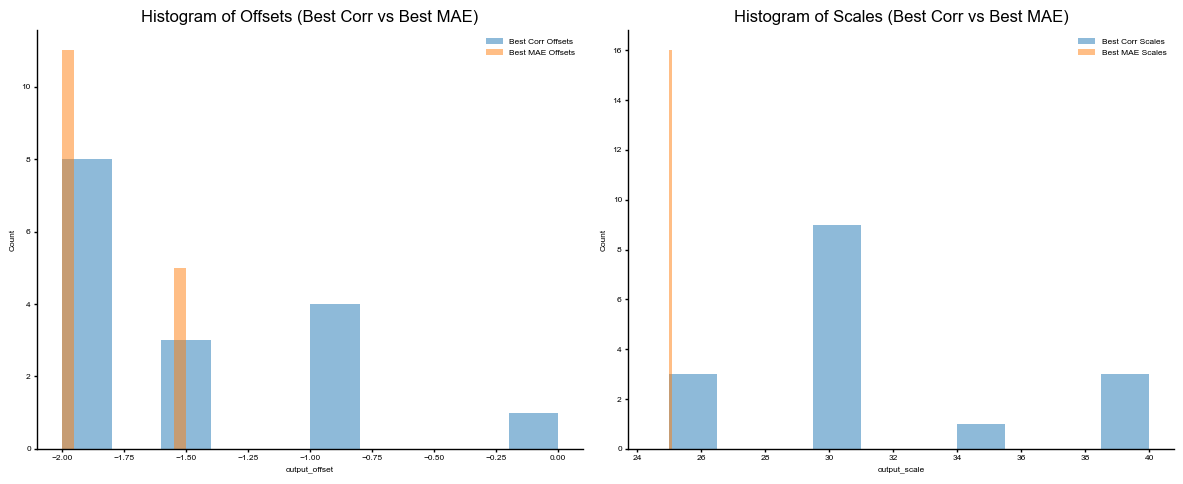

In [13]:
# Suppose you have a list of training run subdirectories:
training_run_files = os.listdir(results_base)

# ROI indices you want to analyze:
all_rois = np.arange(len(roi_field_id))  # or whatever range makes sense in your data

# This will loop over ROIs, produce individual ROI figures (saved to a new directory),
# and create histograms of the most common offset/scale.
analyze_all_rois(
    results_base=results_base,
    training_run_files=training_run_files,
    rois=all_rois,
    split='train',          # or 'test', 'valid', etc.
    save_figs=True          # or pass a string path if you want a specific directory
)
